In [1]:
using Distributions
using LinearAlgebra
using Plots
using Random
Random.seed!(1320)
gr()

Plots.GRBackend()

In [2]:
function compute_approx_likelihoods(true_p1s, ns)
    # Computing ABC posterior estimates
    success_numbers = rand.(Binomial.(ns, true_p1s))
    
    return success_numbers./ns
end

function compute_approx_posterior(true_p1s, ns)
    likelihoods = compute_approx_likelihoods(true_p1s, ns)
    if sum(likelihoods) == 0
        print(true_p1s, ns)
    end
    return normalize(likelihoods, 1)
end

function compute_exact_posterior(true_p1s)
    return normalize(true_p1s, 1)
end

compute_exact_posterior (generic function with 1 method)

In [3]:
function product_or_zero(a,b)
    if (a == 0) & (abs(b) == Inf)
        return 0
    else
        return a*b
    end
end

function kl_divergence(p,q)
    # Computes KL(p,q) for two discrete distributions
    return sum(product_or_zero.(p, log.(p./q)))
end

function compute_posterior_error(approx_posterior, true_posterior; target_f = x -> x)
    n_thetas = length(approx_posterior)
    if target_f == :KL
        return kl_divergence(approx_posterior, true_posterior)
    else
        return sum([(approx_posterior - true_posterior)[i]*target_f(i) for i in 1:n_thetas])
    end
end

function posterior_errors(true_p1s, ns, num_trials; target_f = x -> x)
    return [compute_posterior_error(compute_approx_posterior(true_p1s, ns), compute_exact_posterior(true_p1s); target_f = target_f)
            for i in 1:num_trials]
end

posterior_errors (generic function with 1 method)

In [4]:
function expected_acceptances(true_p1s, ns)
    return dot(true_p1s, ns)
end

function expected_ess(true_p1s, ns; prior = nothing)
    # expected effective sample size
    if prior == nothing
        prior = normalize(ones(length(true_p1s)), 1)
    end
    
    expected_accepted = true_p1s.*ns   
    weights_sum = dot(true_p1s, prior)*sum(ns)    
    squared_weights_sum = sum((prior.^2).*true_p1s./ns)*sum(ns)^2    
    return weights_sum^2 / squared_weights_sum
end
    

expected_ess (generic function with 1 method)

In [5]:
function squared_error_statistics(true_p1s, ns, num_trials = 100; target_f = x -> x)
    raw_errors = posterior_errors(true_p1s, ns, num_trials; target_f = target_f)
    if target_f == :KL
        errors = raw_errors
    else
        errors = norm.(raw_errors).^2
    end
    errors = errors[.~ isnan.(errors)]
    return mean(errors), quantile(errors, 0.25),quantile(errors, 0.75)
end

function predicted_squared_error(true_p1s, ns)
    # assuming two hypothesis, test function difference is 1
    @assert length(true_p1s) == 2
    
    factor_1 = true_p1s[2]*(1 - true_p1s[1])/ns[1] + true_p1s[1]*(1 - true_p1s[2])/ns[2]
    factor_2 = prod(true_p1s)/sum(true_p1s)^4
    return factor_1*factor_2
end

predicted_squared_error (generic function with 1 method)

In [6]:
function all_squared_errors(true_p1s, ns_array; num_trials = 100, target_f = x -> x)
    if length(true_p1s) == 2
        return hcat([vcat(squared_error_statistics(true_p1s, ns, num_trials; target_f = target_f)...,
                            predicted_squared_error(true_p1s, ns)) for ns in ns_array]...)
    else
        return hcat([vcat(squared_error_statistics(true_p1s, ns, num_trials; target_f = target_f)...) for ns in ns_array]...)
    end
end

function all_squared_errors_from_total_n(true_p1s, total_ns, n1_fraction; num_trials = 100, target_f = x -> x)
    ns_array = [[Int64(round(n*n1_fraction)), Int64(round(n*(1-n1_fraction)))] for n in total_ns]
    return all_squared_errors(true_p1s, ns_array, num_trials = num_trials, target_f = target_f)
end



all_squared_errors_from_total_n (generic function with 1 method)

In [7]:
function optimal_n1_fraction(true_p1s)
    a = true_p1s[1]*(1-true_p1s[2])
    b = true_p1s[2]*(1-true_p1s[1])
    return 1/(1 + sqrt(a/b))
end
function optimal_n1_fraction(p1a, p1b)
    return optimal_n1_fraction([p1a, p1b])
end

function unnormalized_variance(true_p1s, n1_fraction)
    # Variance in the estimate of the unnormalized likelihood
    return mean(true_p1s.*(1 .-true_p1s)./[n1_fraction, 1 - n1_fraction])
end

unnormalized_variance (generic function with 1 method)

In [8]:
function all_squared_errors_varying_n1(true_p1s, total_n, n1_fractions; num_trials = 100, target_f = x -> x)
    ns_array = [[Int64(round(total_n*n1_fraction)), Int64(round(total_n*(1-n1_fraction)))] for n1_fraction in n1_fractions]
    return all_squared_errors(true_p1s, ns_array, num_trials = num_trials, target_f = target_f)
end

all_squared_errors_varying_n1 (generic function with 1 method)

In [9]:
true_p1s = [0.3, 0.05]
n1_fractions = 0.01:0.01:0.99
errors = Dict()
kl_errors = Dict()
total_ns = [100, 1000]
for total_n in total_ns
    @time errors[total_n] = all_squared_errors_varying_n1(true_p1s, total_n, n1_fractions, num_trials = 1000)
    @time kl_errors[total_n] = all_squared_errors_varying_n1(true_p1s, total_n, n1_fractions, num_trials = 1000, target_f = :KL)
end

[0.3, 0.05][1, 99][0.3, 0.05][1, 99][0.3, 0.05][3, 97][0.3, 0.05][4, 96][0.3, 0.05][4, 96][0.3, 0.05][4, 96][0.3, 0.05][5, 95][0.3, 0.05][5, 95][0.3, 0.05][6, 94][0.3, 0.05][9, 91][0.3, 0.05][17, 83][0.3, 0.05][20, 80]  1.611862 seconds (5.51 M allocations: 302.827 MiB, 5.04% gc time)
[0.3, 0.05][1, 99][0.3, 0.05][1, 99][0.3, 0.05][1, 99][0.3, 0.05][1, 99][0.3, 0.05][1, 99][0.3, 0.05][3, 97][0.3, 0.05][3, 97][0.3, 0.05][3, 97][0.3, 0.05][3, 97][0.3, 0.05][4, 96][0.3, 0.05][4, 96][0.3, 0.05][5, 95][0.3, 0.05][5, 95]  0.490279 seconds (2.64 M allocations: 123.916 MiB, 3.71% gc time)
  0.073489 seconds (893.99 k allocations: 73.815 MiB, 16.48% gc time)
  0.081545 seconds (1.69 M allocations: 76.249 MiB, 10.21% gc time)


In [10]:
compute_exact_posterior(true_p1s)

2-element Array{Float64,1}:
 0.8571428571428571 
 0.14285714285714288

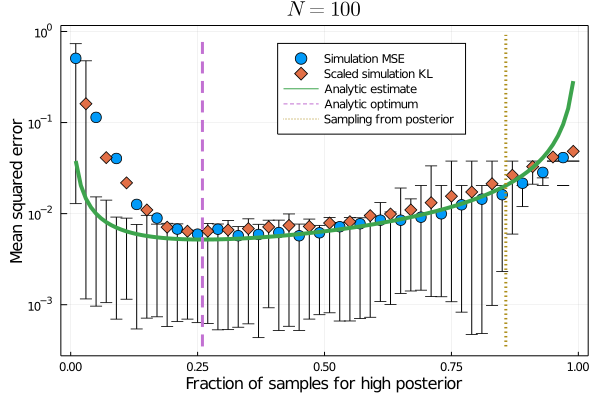

In [11]:
mse_plots = Dict()
for total_n in total_ns
    non_kl_points = 1:4:length(n1_fractions)
    kl_points = 3:4:length(n1_fractions)

    mse_plots[total_n] = scatter(n1_fractions[non_kl_points], errors[total_n][1,non_kl_points],
            yscale = :log10,
            yerr = (errors[total_n][1, non_kl_points] - errors[total_n][2,non_kl_points],
                    errors[total_n][3,non_kl_points] - errors[total_n][1,non_kl_points]),
            m = (6),
            label = "Simulation MSE",
            xlabel = "Fraction of samples for high posterior",
            ylabel = "Mean squared error",
            legend = (0.5, 0.9),
            framestyle = :box,
            title = "\$N = "*string(total_n)*"\$",
        )





    kl_scale = sum(compute_exact_posterior(true_p1s).^(-1))/2
    scaled_kl_errors = kl_errors[total_n]./kl_scale
    scatter!(n1_fractions[kl_points], scaled_kl_errors[1,kl_points],
        yerr = (scaled_kl_errors[1, kl_points] - scaled_kl_errors[2,kl_points],
            scaled_kl_errors[3,kl_points] - scaled_kl_errors[1,kl_points]),
        m = (6, :diamond),
        label = "Scaled simulation KL")

    plot!(n1_fractions, errors[total_n][4,:], label = "Analytic estimate", linewidth = 4)

    linelimits = [ylims(mse_plots[total_n])[1], ylims(mse_plots[total_n])[2]]
    plot!([optimal_n1_fraction(true_p1s), optimal_n1_fraction(true_p1s)], linelimits, label = "Analytic optimum", linewidth = 3, linestyle = :dash)
    plot!([compute_exact_posterior(true_p1s)[1], compute_exact_posterior(true_p1s)[1]], linelimits, label = "Sampling from posterior", linewidth = 3, linestyle = :dot)
end


plot(mse_plots[100], dpi = 100)

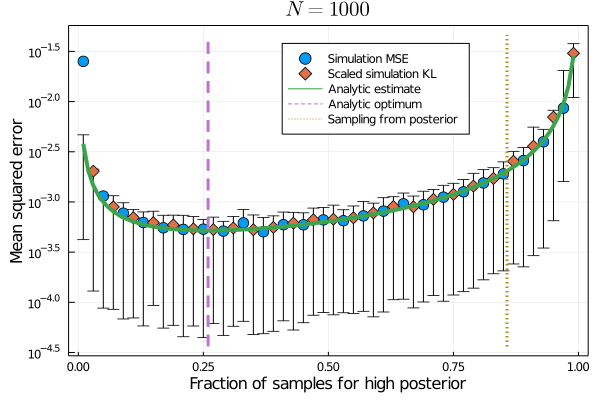

In [12]:
plot(mse_plots[1000], dpi = 100)

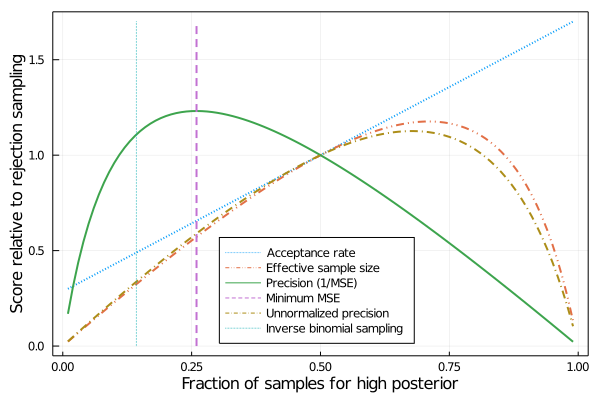

In [13]:

gr()
ess_scale = expected_acceptances(true_p1s, [0.5, 0.5]) # also the acceptances scale, since ESS = num_accepted for rejection
plottable_acceptances = [expected_acceptances(true_p1s, [n1_fraction, 1-n1_fraction]) for n1_fraction in n1_fractions]


p = plot(n1_fractions, plottable_acceptances./ess_scale, ylim = [0,:auto],
    legend = (0.4,0.3),
    label = "Acceptance rate",
    ylabel = "Score relative to rejection sampling",
    xlabel = "Fraction of samples for high posterior",
    framestyle = :box,
    linewidth = 2,
    linestyle = :dot
    )

plottable_ess = [expected_ess(true_p1s, [n1_fraction, 1-n1_fraction]) for n1_fraction in n1_fractions]
plot!(n1_fractions, plottable_ess./ess_scale, ylim = [0,:auto], label = "Effective sample size",
    linewidth = 2,
    linestyle = :dashdotdot)



plot!(n1_fractions, predicted_squared_error(true_p1s, [0.5, 0.5]) ./ [predicted_squared_error(true_p1s, [n1_fraction, 1-n1_fraction]) for n1_fraction in n1_fractions], label = "Precision (1/MSE)", linewidth = 2)
plot!([optimal_n1_fraction(true_p1s), optimal_n1_fraction(true_p1s)], [0,maximum(plottable_acceptances./ess_scale)], label = "Minimum MSE", style = :dash, linewidth = 2)

plot!(n1_fractions, unnormalized_variance(true_p1s, 0.5) ./ ((x -> unnormalized_variance(true_p1s, x)).(n1_fractions)), label = "Unnormalized precision", 
    linewidth = 2,
    linestyle = :dashdot)


ibs_fraction = true_p1s[2]/sum(true_p1s)
plot!([ibs_fraction, ibs_fraction], [0,maximum(plottable_acceptances./ess_scale)], label = "Inverse binomial sampling", style = :dot)

In [14]:
println("Optimal: ", predicted_squared_error(true_p1s, [0.5, 0.5]) ./predicted_squared_error(true_p1s, [optimal_n1_fraction(true_p1s), 1 - optimal_n1_fraction(true_p1s)]))
println("IBS: ", predicted_squared_error(true_p1s, [0.5, 0.5]) ./predicted_squared_error(true_p1s, normalize([1/true_p1s[1], 1/true_p1s[2]], 1)))
println("ESS: ", predicted_squared_error(true_p1s, [0.5, 0.5]) ./predicted_squared_error(true_p1s, normalize(sqrt.(true_p1s), 1)))
println("Unnormalized: ", predicted_squared_error(true_p1s, [0.5, 0.5]) ./predicted_squared_error(true_p1s, normalize(sqrt.(true_p1s) .* sqrt.(1 .-true_p1s), 1)))


println("ESS for ESS: ", expected_ess(true_p1s, normalize(sqrt.(true_p1s), 1))/expected_ess(true_p1s, [0.5, 0.5]))
println("ESS for optimal: ", expected_ess(true_p1s, [optimal_n1_fraction(true_p1s), 1 - optimal_n1_fraction(true_p1s)])/expected_ess(true_p1s, [0.5, 0.5]))

Optimal: 1.2313616020031304
IBS: 1.1082251082251082
ESS: 0.6199188047272834
Unnormalized: 0.6838371398511223
ESS for ESS: 1.1765714880828406
ESS for optimal: 0.5720858049943367
